In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

path ='/home/jovyan/wenben/'
traindata_path = path + 'splited_words.csv'
df = pd.read_csv(traindata_path, header=None)
df.columns = ['labels','words']
df.drop(0,inplace=True)


In [2]:
#打乱数据
df = df.sample(frac = 1).reset_index(drop=True)

#标签存储到文件中的时候是string 将其转换为Float
labels = pd.DataFrame(df['labels'],dtype=np.float)

#将数据集按9:1分为训练集和测试集
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['words'], labels, test_size=0.1)

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#创建一个Tokenizer对象，fit_on_texts函数可以将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['words'])
word_index = tokenizer.word_index

# 将每个样本中的每个词转换为数字列表，使用每个词的编号进行编号
x_train_word_ids = tokenizer.texts_to_sequences(x_train)
x_test_word_ids = tokenizer.texts_to_sequences(x_test)

maxlen = 412

# 每条样本长度不唯一，将每条样本的长度设置一个固定值
x_train_padded_seqs=pad_sequences(x_train_word_ids,maxlen) #将超过固定值的部分截掉，不足的在最前面用0填充
x_test_padded_seqs=pad_sequences(x_test_word_ids, maxlen)

print('Shape of data tensor:', len(x_train_word_ids))



Shape of data tensor: 374


In [4]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import logging
import numpy as np


w2vmodel_path = path + 'w2v_model.word2vec'
w2v_model=Word2Vec.load(w2vmodel_path)

# 预训练的词向量中没有出现的词用0向量表示，出现的词在w2v模型中找到其对应的向量
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    try:
        embedding_vector = w2v_model[str(word)]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        continue
        
embedding_vector

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


array([ 0.03077555, -0.19689171,  0.01514873,  0.03516552, -0.14649189,
        0.13536552,  0.05067921,  0.14673224,  0.05071287,  0.11778942,
       -0.20570518, -0.03077563, -0.02187294,  0.10823867, -0.19002423,
        0.01003067,  0.02210338,  0.04537965, -0.02104371, -0.08242097,
        0.07172298, -0.05729886, -0.09972931, -0.05655343,  0.3411734 ,
        0.02328766,  0.0683514 ,  0.0731271 , -0.02935319,  0.00482498,
       -0.00855024, -0.07526612,  0.05240898, -0.04589947, -0.18190417,
        0.05480899, -0.15392256, -0.15008   , -0.06484099, -0.07939017,
        0.16987318, -0.07401173, -0.16184033, -0.07768875,  0.17417845,
        0.12553489, -0.02140648, -0.18119417, -0.27416858,  0.09680711,
        0.07791966,  0.08012443,  0.07039854,  0.124543  , -0.2993557 ,
        0.18695877, -0.06365933,  0.08606162,  0.08195942, -0.07990877,
       -0.00325763, -0.09464441, -0.11443657, -0.10910913,  0.02579219,
       -0.02725696,  0.07959891,  0.02723507, -0.03452498, -0.22

In [5]:
#注意力机制层

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
from matplotlib import pyplot as plt
import pandas as pd
 
from tensorflow.keras import backend as K
from tensorflow.python.keras.layers import Layer, InputSpec
 
class Self_Attention(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它

    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
 
        print("WQ.shape",WQ.shape)
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
        QK = QK / (64**0.5)
        QK = K.softmax(QK)
        print("QK.shape",QK.shape)
        V = K.batch_dot(QK,WV)
        return V
 
    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[1],self.output_dim)

In [6]:
from tensorflow.keras.layers import Input,Embedding,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras.layers import BatchNormalization,Dense,Dropout,Lambda
from tensorflow.keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,Dropout,Lambda
from tensorflow.keras import Sequential
import numpy as np

model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Self_Attention(128))
model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(Dense(labels.shape[1],activation="sigmoid")) 

model.compile(loss='mse', optimizer='adam', metrics=['accuracy','mae'])

history = model.fit(x_train_padded_seqs, y_train, epochs=20, batch_size=20)



WQ.shape (None, 412, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 412)
QK.shape (None, 412, 412)
Epoch 1/20
WQ.shape (None, 412, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 412)
QK.shape (None, 412, 412)
WQ.shape (None, 412, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 412)
QK.shape (None, 412, 412)
19/19 [==============================] - 9s 491ms/step - loss: 0.0658 - accuracy: 0.9118 - mae: 0.1354
Epoch 2/20
19/19 [==============================] - 10s 501ms/step - loss: 0.0370 - accuracy: 0.9519 - mae: 0.0791
Epoch 3/20
19/19 [==============================] - 9s 459ms/step - loss: 0.0339 - accuracy: 0.9492 - mae: 0.0805
Epoch 4/20
19/19 [==============================] - 9s 490ms/step - loss: 0.0268 - accuracy: 0.9679 - mae: 0.0591
Epoch 5/20
19/19 [==============================] - 9s 489ms/step - loss: 0.0183 - accuracy: 0.9733 - mae: 0.0441
Epoch 6/20
19/19 [==============================] - 9s 500ms/step - loss: 0.0240 - accuracy: 0.9

In [7]:

#!pip3 install pydot_ng
#画出模型图
import os
from keras.utils import plot_model
os.environ["PATH"] += os.pathsep + 'D:\\graphviz\\bin'
#生成一个模型图，第一个参数为模型，第二个参数为要生成图片的路径及文件名，还可以指定两个参数：
#show_shapes:指定是否显示输出数据的形状，默认为False
#show_layer_names:指定是否显示层名称，默认为True
model_path = path + 'lstm_w2v_model.png'
plot_model(model,to_file=model_path,show_shapes=True,show_layer_names=False)

ModuleNotFoundError: No module named 'keras'

<class 'tensorflow.python.keras.callbacks.History'>
WQ.shape (None, 412, 128)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 128, 412)
QK.shape (None, 412, 412)
[3.1135020890360465e-06, 1.0, 0.0010529214050620794]


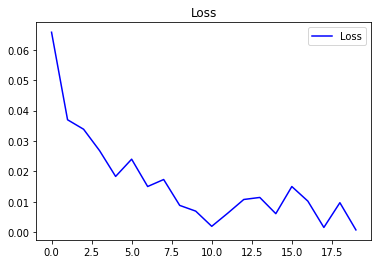

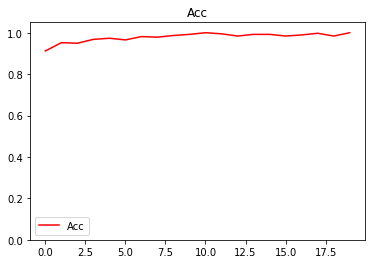

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

print(type(history))
plt.title('Loss')
epochs=range(len(history.history["loss"])) # Get number of epochs
plt.plot(epochs,history.history["loss"],'b')
plt.legend(["Loss"])
plt.figure()

plt.title('Acc')
plt.ylim([0.0, 1.05])
plt.plot(epochs,history.history["accuracy"],'r')
plt.legend(["Acc"])
plt.figure()

#估计评分
scores = model.evaluate(x_test_padded_seqs,y_test,verbose = 0)
print(scores)